# CPD Complaints Analysis
In this notebook, we examine (mostly civilian) complaints filed against the Chicago Police Department from 2006 to 2016. This supplements our efforts in our previous notebook: [1. Baseline EDA](https://www.kaggle.com/loganchang/baseline-eda), where we analyze more detailed, but officer-reported tactical response reports (TRRs). Our goal here is to compare and contrast the data from both perspectives, perhaps uncovering patterns such as police underreporting.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/complaints-data/complaints-accused_2000-2016_2016-11.csv
/kaggle/input/complaints-data/complaints-victims_2000-2016_2016-11.csv
/kaggle/input/complaints-data/beatlist.txt
/kaggle/input/complaints-data/complaints-complaints_2000-2016_2016-11.csv


In [2]:
df_detail = pd.read_csv("/kaggle/input/complaints-data/complaints-accused_2000-2016_2016-11.csv")
df_victims = pd.read_csv("/kaggle/input/complaints-data/complaints-victims_2000-2016_2016-11.csv")
df_main = pd.read_csv("/kaggle/input/complaints-data/complaints-complaints_2000-2016_2016-11.csv")

## DF_MAIN Processed Below

In [3]:
df_main.head()

,row_id,cr_id,beat,location_code,address_number,street,apartment_number,city_state,incident_date,incident_time,complaint_date,closed_date
0,1,258996,1524,04,5327,W CHICAGO,NaN,CHICAGO IL,2000-01-01,01:20:00,2000-01-01,2001-01-26
1,2,258997,1115,17,4316,W JACKSON,NaN,CHICAGO IL,2000-01-01,01:30:00,2000-01-01,2000-10-14
2,3,258998,1834,17,500,W ILLINOIS,NaN,CHICAGO IL,2000-01-01,00:28:00,2000-01-01,2001-01-18
3,4,258999,0,17,NaN,NaN,NaN,CHICAGO IL,2000-01-01,03:30:00,2000-01-01,2000-03-23
4,5,259000,1524,04,5327,W CHICAGO AVE,NaN,CHICAGO IL,2000-01-01,05:00:00,2000-01-01,2001-01-17


In [4]:
df_main.columns

Index(['row_id', 'cr_id', 'beat', 'location_code', 'address_number', 'street',
       'apartment_number', 'city_state', 'incident_date', 'incident_time',
       'complaint_date', 'closed_date'],
      dtype='object')

In [5]:
#remove unnecessary info
df_main = df_main.drop(["row_id", "location_code", "address_number", "street", "apartment_number", "incident_time", "complaint_date","closed_date"], axis=1)

Create a year category as specific dates are superfluous...

In [6]:
#creating year and dropping date columns
df_main['incident_year'] = df_main['incident_date'].apply(lambda x: int(x[0:4]))
df_main.drop(['incident_date'], axis = 1, inplace = True)

In previously previewing our data, we found that only CR_ID's greater than or equal to 1000000 were present across all data sets. Let's take out the data that doesn't apply...

In [7]:
#pruning our data to only contain CR_ID's >= 1000000 as these are the CR_ID's present across all data sets
df_main = df_main[df_main.cr_id >= 1000000]

In [8]:
df_main.head()

,cr_id,beat,city_state,incident_year
27715,1000258,1324,CHICAGO IL,2002
27716,1000564,1722,CHICAGO IL,2002
27717,1002540,1024,CHICAGO IL,2002
27718,1004717,1121,CHICAGO IL,2002
27719,1005444,2532,-----,2002


We have a file that contains the name of each beat in the CPD. We will use it to make sure each complaint occurs in a relevatn beat....

In [9]:
#open and read CPD beats file
beatset = set([])
beatf = open("/kaggle/input/complaints-data/beatlist.txt",'r')
N = int(beatf.readline()[:-1])
for i in range(N):
    beatset.add(beatf.readline()[:-1])

In [10]:
#helper func to easily pull beat names and ensure that each beat is a part of the beats file we previously opened and read
def pad0(string, length):
    if (type(string) != str):
        string = str(int(string))
    ans = ""
    for i in range(length-len(string)):
        ans += '0'
    ans += string
    if (ans in beatset):
        return ans
    else:
        return "asdf"

#helper func to ensure all complaints in the Chicago-Metro Area
def city_state_checker(string):
    if string[:2] != "CH" or string == "CHICAGO RIDG IL":
        return "bAd"
    return "gOOd"

In [11]:
#applying above funcs to data for removing data with irrelevant beats and formatting exisiting beats
df_main = df_main[~pd.isna(df_main.beat)]
df_main.beat = df_main.beat.apply(lambda x: pad0(x, 4))
df_main = df_main[df_main.beat != "asdf"]

In [12]:
#applying above helper funcs to remove all complaints not in our geographic area of interests
df_main = df_main[~pd.isna(df_main.city_state)]
df_main.city_state = df_main.city_state.apply(lambda x: city_state_checker(x))
df_main = df_main[df_main.city_state != "bAd"]

In [13]:
#the above function removed need for 'city_state' column so let's drop
df_main = df_main.drop(["city_state"], axis=1)

In [14]:
#index by CR ID for easy sorting/combining
df_main = df_main.set_index("cr_id")

In [15]:
df_main.head()

,beat,incident_year
cr_id,,
1000564,1722,2002
1002540,1024,2002
1004717,1121,2002
1006193,0531,2000
1012608,0726,2001


## DF_VICTIMS Processed Below

In [16]:
df_victims.head()

,cr_id,gender,age,race
0,1000009,FEMALE,37.0,HISPANIC
1,1000015,FEMALE,35.0,BLACK
2,1000015,FEMALE,24.0,BLACK
3,1000020,MALE,27.0,BLACK
4,1000021,MALE,26.0,BLACK


In [17]:
#remove null values for race
df_victims = df_victims[~pd.isna(df_victims["race"])]

In [18]:
#set index to CR ID for easy sorting/combining
df_victims = df_victims.set_index("cr_id")

In [19]:
df_victims.head()

,gender,age,race
cr_id,,,
1000009,FEMALE,37.0,HISPANIC
1000015,FEMALE,35.0,BLACK
1000015,FEMALE,24.0,BLACK
1000020,MALE,27.0,BLACK
1000021,MALE,26.0,BLACK


# DF_DETAIL Processed Below

In [20]:
df_detail.head()

,row_id,complaints-accused_2000-2016_2016-11_ID,cr_id,complaint_category,recommended_discipline,final_discipline,recommended_finding,final_finding,UID
0,1,15646.0,258996,01A-USE OF PROFANITY,600.0,600.0,NS,NS,130754
1,2,8602.0,258997,01A-USE OF PROFANITY,600.0,600.0,UN,UN,117163
2,3,6951.0,258997,01A-USE OF PROFANITY,600.0,600.0,UN,UN,113991
3,4,13745.0,258998,10J-NEGLECT OF DUTY/CONDUCT UNBECOMING - ON DUTY,600.0,600.0,EX,EX,127168
4,5,918.0,259001,10U-INADEQUATE/FAILURE TO PROVIDE SERVICE,600.0,600.0,UN,UN,101654


Again, the only overlapping data across all three datasets is for CR IDs greater than or equal to 1000000, so let's get rid of all CR IDs that don't fit this criteria...

In [21]:
#removing all CR ID < 1000000
df_detail = df_detail[df_detail["cr_id"] >= 1000000]

In [22]:
#set index to CR ID for easy sorting/combining
df_detail = df_detail.set_index("cr_id")

In [23]:
#drop an unnecessary column
df_detail = df_detail.drop(["complaints-accused_2000-2016_2016-11_ID", "UID"], axis=1)

In [24]:
df_detail.head()

,row_id,complaint_category,recommended_discipline,final_discipline,recommended_finding,final_finding
cr_id,,,,,,
1000258,33057,03D-ILLEGAL ARREST,600.0,600.0,UN,UN
1000258,33058,03D-ILLEGAL ARREST,600.0,600.0,UN,UN
1000258,33059,03D-ILLEGAL ARREST,600.0,600.0,UN,UN
1000258,33060,03D-ILLEGAL ARREST,600.0,600.0,UN,UN
1000258,33061,03D-ILLEGAL ARREST,600.0,600.0,UN,UN


## Looking at all dataframes simulatenously:

In [25]:
df_main = df_main.sort_index()
df_victims = df_victims.sort_index()
df_detail = df_detail.sort_index()

In [26]:
df_main.drop_duplicates(inplace = True)
df_detail.drop_duplicates(inplace = True)

In [27]:
df_main.head()

,beat,incident_year
cr_id,,
1000001,1014,2006
1000004,0821,2006
1000006,0712,2006
1000007,1022,2006
1000010,0323,2006


In [28]:
df_victims.head()

,gender,age,race
cr_id,,,
1000009,FEMALE,37.0,HISPANIC
1000015,FEMALE,35.0,BLACK
1000015,FEMALE,24.0,BLACK
1000020,MALE,27.0,BLACK
1000021,MALE,26.0,BLACK


In [29]:
df_detail.head()

,row_id,complaint_category,recommended_discipline,final_discipline,recommended_finding,final_finding
cr_id,,,,,,
1000002,62185,05M-UNNECESSARY PHYSICAL CONTACT - OFF DUTY,600.0,600.0,UN,UN
1000002,62186,05M-UNNECESSARY PHYSICAL CONTACT - OFF DUTY,600.0,600.0,UN,UN
1000004,62188,05N-WEAPON - UNNECESSARY DISPLAY OF,5.0,5.0,SU,SU
1000004,62187,05N-WEAPON - UNNECESSARY DISPLAY OF,5.0,1.0,SU,SU
1000006,62189,05A-ARRESTEE - DURING ARREST,600.0,600.0,NS,NS


In [30]:
df_main.shape

(3057, 2)

In [31]:
df_victims.shape

(19103, 3)

In [32]:
df_detail.shape

(63719, 6)

# Starting some EDA...

**DF_MAIN:**

In [33]:
df_main.head()

,beat,incident_year
cr_id,,
1000001,1014,2006
1000004,0821,2006
1000006,0712,2006
1000007,1022,2006
1000010,0323,2006


Let's see which beats and which districts had the highest and lowest number of complaints...

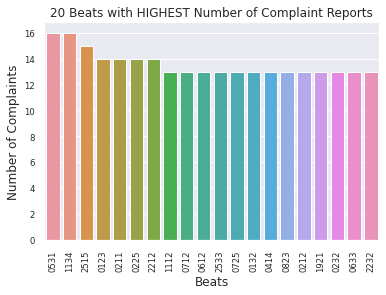

In [34]:
#graph for beats with most complaints
beatFreq = df_main.beat.value_counts()[:20]
beatFreq_beats = beatFreq.index
sns.set(font_scale = 1)
ax = sns.barplot(x = beatFreq_beats, y = beatFreq, order = beatFreq_beats, label = 'small')
ax.set_title('20 Beats with HIGHEST Number of Complaint Reports')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(xlabel='Beats', ylabel='Number of Complaints')
ax.tick_params(labelsize=8.5)
plt.show()

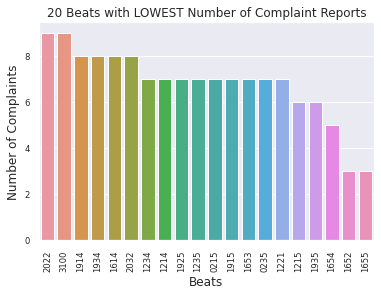

In [35]:
#graph for beats with least complaints
beatFreq_low = df_main.beat.value_counts()[-20:]
beatFreq_low_beats = beatFreq_low.index
sns.set(font_scale = 1)
ax = sns.barplot(x = beatFreq_low_beats, y = beatFreq_low, order = beatFreq_low_beats, label = 'small')
ax.set_title('20 Beats with LOWEST Number of Complaint Reports')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(xlabel='Beats', ylabel='Number of Complaints')
ax.tick_params(labelsize=8.5)
plt.show()

Sorting the above graphs by district...(which is the first two digits in the beat name)

In [36]:
#counter dict for district with most beats in top 20
districts_high = {}
for beat in beatFreq_beats:
    district = beat[:2]
    if district in districts_high.keys():
        districts_high[district] += 1
    else:
        districts_high[district] = 1
#print(districts_high)
districts_high_sorted_keys = sorted(districts_high, key=districts_high.get, reverse=True)
districts_high_sort ={}
for district in districts_high_sorted_keys:
    districts_high_sort[district] = districts_high[district]
print(districts_high_sort)

{'02': 4, '11': 2, '25': 2, '01': 2, '22': 2, '07': 2, '06': 2, '05': 1, '04': 1, '08': 1, '19': 1}


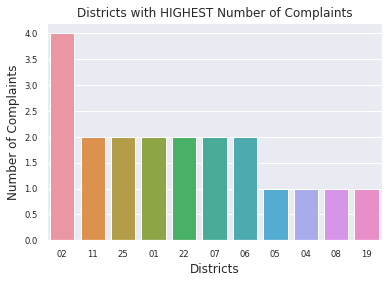

In [37]:
#graph of above counter
sns.set(font_scale = 1)
ax = sns.barplot(x = list(districts_high_sort.keys()), y = list(districts_high_sort.values()), order = districts_high_sort, label = 'small')
ax.set_title('Districts with HIGHEST Number of Complaints')
ax.set_xticklabels(ax.get_xticklabels())
ax.tick_params(labelsize=8.5)
ax.set(xlabel='Districts', ylabel='Number of Complaints')
plt.show()

**Key Takeaways:**
* Districts 2 and  11 in consistently high across all categories we have measured so far...

*Note: the above graphs represents the frequency of each district in '20 Beats with the Highest Number of Complaints' data (i.e. 4 beats in District 11 were in the 20 Beats with the Highest Number of Complaints' data)*

In [38]:
#counter dict for district with most beats in bottom 20
districts_low = {}
for beat in beatFreq_low_beats:
    district = beat[:2]
    if district in districts_low.keys():
        districts_low[district] += 1
    else:
        districts_low[district] = 1
#print(districts_low)
districts_low_sorted_keys = sorted(districts_low, key=districts_low.get, reverse=True)
districts_low_sort ={}
for district in districts_low_sorted_keys:
    districts_low_sort[district] = districts_low[district]
print(districts_low_sort)

{'19': 5, '16': 5, '12': 5, '20': 2, '02': 2, '31': 1}


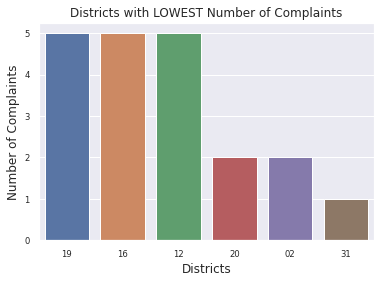

In [39]:
#graph of above counter
sns.set(font_scale = 1)
ax = sns.barplot(x = list(districts_low_sort.keys()), y = list(districts_low_sort.values()), order = districts_low_sort, label = 'small')
ax.set_title('Districts with LOWEST Number of Complaints')
ax.set_xticklabels(ax.get_xticklabels())
ax.tick_params(labelsize=8.5)
ax.set(xlabel='Districts', ylabel='Number of Complaints')
plt.show()

**Key Takeaways:**
* The prominence of Districts 12, 16, and 19 at the bottom match the trends we saw in the other data

We won't note any observations until we cross-reference with the beat/district data in the 'Baseline EDA' notebook, but we can tell you from first glance we already see some intersting overlaps acorss all beat/district data, which we will go into greater depth with in our cross-reference notebook

We can look at the frequency of complaint reports filed by year too...

In [40]:
print(df_main.incident_year.value_counts())

2012    273
2011    273
2014    273
2013    272
2010    270
2015    269
2009    262
2008    261
2007    257
2006    249
2016    234
2005     79
2004     30
2001     25
2003     12
2002     10
2000      8
Name: incident_year, dtype: int64


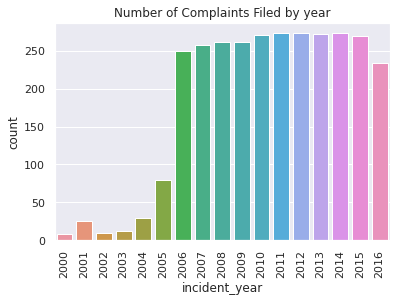

In [41]:
#graph of frequency each year appears across all available complaint data
ax = sns.countplot(x="incident_year", data=df_main)
ax.set_title('Number of Complaints Filed by year')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

**Key Takeaways:**
* Complaints are far more frequent since 2005. This could be due to an uptick in complaints in recent years or an increase in digital recoards recently

**DF_VICTIMS**

In [42]:
df_victims.head()

,gender,age,race
cr_id,,,
1000009,FEMALE,37.0,HISPANIC
1000015,FEMALE,35.0,BLACK
1000015,FEMALE,24.0,BLACK
1000020,MALE,27.0,BLACK
1000021,MALE,26.0,BLACK


Let's look at the breakdown of complainees by gender, race, and age...

First, gender:

In [43]:
#counter for gender frequency across all available complaints
print(df_victims.gender.value_counts())

MALE      12623
FEMALE     6476
Name: gender, dtype: int64


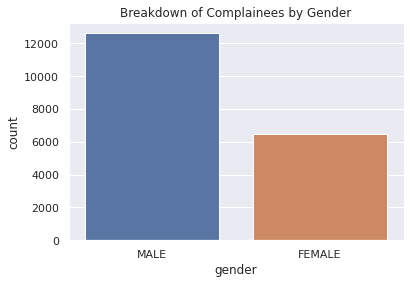

In [44]:
#graph of above counter
ax = sns.countplot(x="gender", data=df_victims,  order = df_victims.gender.value_counts().index)
ax.set_title('Breakdown of Complainees by Gender')
plt.show()

Now, race:

In [45]:
#counter for race frequency across all available complaints
print(df_victims.race.value_counts())

BLACK                             13804
HISPANIC                           2774
WHITE                              2352
ASIAN/PACIFIC ISLANDER              159
NATIVE AMERICAN/ALASKAN NATIVE       14
Name: race, dtype: int64


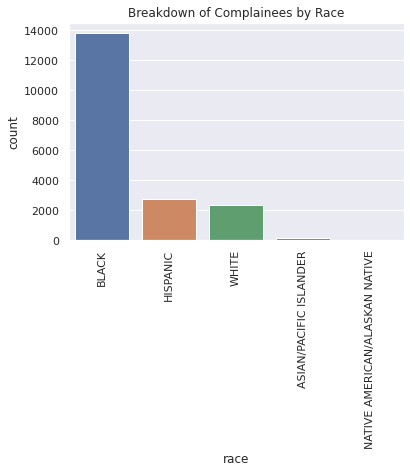

In [46]:
#graph of above counter
ax = sns.countplot(x="race", data=df_victims, order = df_victims.race.value_counts().index)
ax.set_title('Breakdown of Complainees by Race')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

Lastly, age... 

*(We will group ages by certain age ranges in order to make the graphs more readable)*

In [47]:
#helper func to create age ranges
def bander(age):
    if (age<20):
        return '<20'
    elif(age>=20 and age<30):
        return '20-29'
    elif(age>=30 and age<40):
        return '30-39'
    elif(age>=40 and age<50):
        return '40-49'
    elif(age>=50 and age<60):
        return '50-59'
    elif(age>=60 and age<70):
        return '60-69'
    else:
        return '>=70'

In [48]:
#apply helper func to complete complaints data
df_victims['age_band'] = df_victims.age.apply(lambda x: bander(x))

In [49]:
#view of frequency of age band
df_victims.age_band.value_counts()

20-29    5913
30-39    3842
>=70     3530
40-49    2341
50-59    1620
<20      1199
60-69     658
Name: age_band, dtype: int64

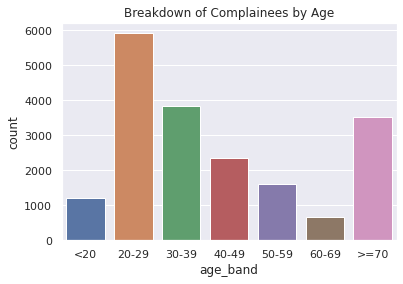

In [50]:
#graph of above counter
age_band_order = ['<20', '20-29','30-39','40-49','50-59','60-69', '>=70' ]
ax = sns.countplot(x="age_band", data=df_victims, order = age_band_order)
ax.set_title('Breakdown of Complainees by Age')
plt.show()

Let's put all this data into a useful table...

In [51]:
df_victims.drop('age', axis = 1, inplace = True)

In [52]:
pd.set_option('display.max_rows', None)
table = pd.pivot_table(df_victims, index=['race', 'gender', 'age_band'], aggfunc= len, fill_value = 0)
table

race                            gender  age_band
ASIAN/PACIFIC ISLANDER          FEMALE  20-29          6
                                        30-39          9
                                        40-49          9
                                        50-59          2
                                        60-69          2
                                        >=70          15
                                MALE    20-29         29
                                        30-39         18
                                        40-49         16
                                        50-59         11
                                        60-69          4
                                        <20            1
                                        >=70          37
BLACK                           FEMALE  20-29       1306
                                        30-39        800
                                        40-49        585
                                       

**Key Takeaways:**
* Complaints are filed by black citizens nearly 6x more than any other race group
* Roughly twice as many complaints were filed by men than by women
* The most common subgroup were black males in their 20's, but black males in general filed many complaints
* We also see elderly citizens (>=70 years old) filed a vast number of complaints across every race and gender category

**Key Takeaways:**

**DF_DETAIL**

In [53]:
df_detail.head()

,row_id,complaint_category,recommended_discipline,final_discipline,recommended_finding,final_finding
cr_id,,,,,,
1000002,62185,05M-UNNECESSARY PHYSICAL CONTACT - OFF DUTY,600.0,600.0,UN,UN
1000002,62186,05M-UNNECESSARY PHYSICAL CONTACT - OFF DUTY,600.0,600.0,UN,UN
1000004,62188,05N-WEAPON - UNNECESSARY DISPLAY OF,5.0,5.0,SU,SU
1000004,62187,05N-WEAPON - UNNECESSARY DISPLAY OF,5.0,1.0,SU,SU
1000006,62189,05A-ARRESTEE - DURING ARREST,600.0,600.0,NS,NS


In [54]:
#store all the complaint categories in a neat list
complaint_cat_list = list(df_detail.complaint_category.unique())

Use dict for complaint categories...

*Each complaint has a 3 character alphanumeric key and a longer description. We will only display the 3 character alphanumeric key and keep the corresponding description in a seperate space.*

In [55]:
#create a dict for the above said 3-character key and the corresponding description
complaint_cat_dict = {}
for x in complaint_cat_list:
    desc = str(x)
    key = desc[:3]
    DESC = desc[4:]
    complaint_cat_dict[key] = DESC
print(len(complaint_cat_dict))

123


In [56]:
#remove the descriptions from the complaints
df_detail['complaint_key'] = df_detail.complaint_category.apply(lambda x: str(x)[:3])

In [57]:
#we don't need all full descriptions anymore, so drop
df_detail.drop('complaint_category', axis = 1, inplace = True)

In [58]:
#replacing null values with 'OTHER'
df_detail['complaint_key'].replace('nan', 'OTHER', inplace = True)

In [59]:
#before removing dups (uncomment if needed but long)
#df_detail.complaint_key.value_counts()

In [60]:
#removing some auxilary category
df_detail.drop('row_id', axis = 1, inplace = True)

**Important Note:**

We found many of the complaints here had identical info across all categories. We labeled such instances as 'duplicates'. As we were unable to discern whether these 'duplicate' complaints were unique incidients under the same complaint ID or cloned data, we will run our remaining analysis on a dataset with all data and on data without said 'duplicates', which we will denote in all our outputs as 'No Dups'

In [61]:
#creating our no dups dataframe
df_detail_no_dups = df_detail.drop_duplicates()

In [62]:
#after removing dups (uncomment if needed but long)
#df_detail_no_dups.complaint_key.value_counts()

Looking at complaint types...

In [63]:
#table of 20 most frequent complaint types in duplicates data
print('20 Most Frequent Complaint Types (With Duplicates) — Table\n')
for key in df_detail.complaint_key.value_counts()[:20].index:
    if(key == 'OTHER'):
        print('OTHER')
        print("Frequency: "+str(df_detail.complaint_key.value_counts()[key]))
        print('-'*50)
    else:
        print(key+": "+complaint_cat_dict[key])
        print("Frequency: "+str(df_detail.complaint_key.value_counts()[key]))
        print('-'*50)

20 Most Frequent Complaint Types (With Duplicates) — Table

10U: INADEQUATE/FAILURE TO PROVIDE SERVICE
Frequency: 10111
--------------------------------------------------
05A: ARRESTEE - DURING ARREST
Frequency: 6238
--------------------------------------------------
03D: ILLEGAL ARREST
Frequency: 5900
--------------------------------------------------
03G: MISCELLANEOUS
Frequency: 5566
--------------------------------------------------
03C: SEARCH OF PREMISE/VEHICLE WITHOUT WARRANT
Frequency: 4898
--------------------------------------------------
10Z: MISCELLANEOUS
Frequency: 3071
--------------------------------------------------
10J: NEGLECT OF DUTY/CONDUCT UNBECOMING - ON DUTY
Frequency: 2573
--------------------------------------------------
04E: PRISONER'S PROPERTY - INVENTORY/RECEIPT
Frequency: 2391
--------------------------------------------------
03B: SEARCH OF PERSON WITHOUT WARRANT
Frequency: 2345
--------------------------------------------------
05B: ARRESTEE - AFTER ARR

**Key Takeaways:**
* The most common complaint types were usually complaints involving some form of impropoer arrest or search
* Rarely do we see any sort of physical abuse or racial prejudice being presented, but such complaints still occur with relative frequency

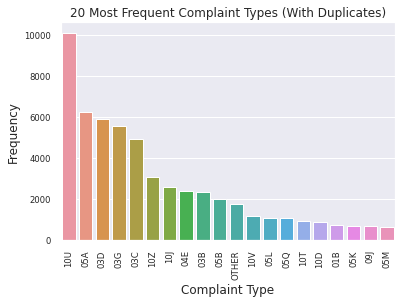

In [64]:
#graph of above data via frequency
sns.set(font_scale = 1)
ax = sns.barplot(x = df_detail.complaint_key.value_counts()[:20].index, y = df_detail.complaint_key.value_counts()[:20], order = df_detail.complaint_key.value_counts()[:20].index, label = 'small')
ax.set_title('20 Most Frequent Complaint Types (With Duplicates)')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(xlabel='Complaint Type', ylabel='Frequency')
ax.tick_params(labelsize=8.5)
plt.show()

In [65]:
#table of 20 most frequent complaint types in no duplicates data
print('20 Most Frequent Complaint Types (No Duplicates) — Table\n')
for key in df_detail_no_dups.complaint_key.value_counts()[:20].index:
    print(key+": "+complaint_cat_dict[key])
    print("Frequency: "+str(df_detail_no_dups.complaint_key.value_counts()[key]))
    print('-'*50)

20 Most Frequent Complaint Types (No Duplicates) — Table

10J: NEGLECT OF DUTY/CONDUCT UNBECOMING - ON DUTY
Frequency: 141
--------------------------------------------------
10Z: MISCELLANEOUS
Frequency: 120
--------------------------------------------------
09J: MISCELLANEOUS
Frequency: 110
--------------------------------------------------
10M: INSUBORDINATION
Frequency: 90
--------------------------------------------------
10U: INADEQUATE/FAILURE TO PROVIDE SERVICE
Frequency: 86
--------------------------------------------------
10B: MEDICAL ROLL
Frequency: 80
--------------------------------------------------
10L: WEAPON/AMMUNITION/UNIFORM DEVIATION
Frequency: 71
--------------------------------------------------
10T: REPORTS - FAILED TO SUBMIT/IMPROPER
Frequency: 68
--------------------------------------------------
10P: MISUSE OF DEPARTMENT EQUIPMENT/SUPPLIES
Frequency: 67
--------------------------------------------------
05A: ARRESTEE - DURING ARREST
Frequency: 65
-------------

**Key Takeaways:**
* The complaints listed here are a lot more 'menial' than the complaints in the data with duplicates, suggesting the types of complaints prevelant in the duplicate data are much more common...
* The types of complaints listed here are lots of police misuse of equipment or miscellaneous complaints

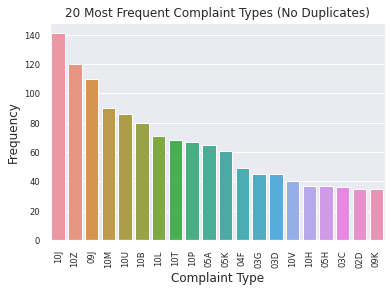

In [66]:
#graph of above data via frequency
sns.set(font_scale = 1)
ax = sns.barplot(x = df_detail_no_dups.complaint_key.value_counts()[:20].index, y = df_detail_no_dups.complaint_key.value_counts()[:20], order = df_detail_no_dups.complaint_key.value_counts()[:20].index, label = 'small')
ax.set_title('20 Most Frequent Complaint Types (No Duplicates)')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(xlabel='Complaint Type', ylabel='Frequency')
ax.tick_params(labelsize=8.5)
plt.show()

Now looking at disciplines...


In [67]:
df_detail.reset_index(level = 0, inplace = True)
df_detail_no_dups.reset_index(level = 0, inplace = True)

In [68]:
#discipline code counter for duplicate data + sorting (recommended discipline)
discipline_dict_rec = {}
discipline_dict_rec['x Day Suspension'] = 0
discipline_dict_rec['Over 30 Day Suspension'] = 0
discipline_dict_rec['Reprimanded'] = 0
discipline_dict_rec['Administrative Termination'] = 0
discipline_dict_rec['Year-long Suspension or Longer'] = 0
discipline_dict_rec['Seperation'] = 0
discipline_dict_rec['Reinstated'] = 0
discipline_dict_rec['Nothing'] = 0
discipline_dict_rec['Resigned'] = 0
for ind in df_detail.index:
    rec = df_detail['recommended_discipline'][ind]
    if rec <199:
        discipline_dict_rec['x Day Suspension'] += 1
    if rec == 200:
        discipline_dict_rec['Over 30 Day Suspension'] +=1
    if rec == 0 or rec == 100:
        discipline_dict_rec['Reprimanded'] += 1
    if rec == 300:
        discipline_dict_rec['Administrative Termination'] +=1
    if rec == 365:
        discipline_dict_rec['Year-long Suspension or Longer'] +=1
    if rec == 400:
        discipline_dict_rec['Seperation'] += 1
    if rec == 500:
        discipline_dict_rec['Reinstated'] += 1
    if rec == 600 or rec == 900:
        discipline_dict_rec['Nothing'] += 1
    if rec == 800:
        discipline_dict_rec['Resigned'] += 1
discipline_dict_rec_keys = sorted(discipline_dict_rec, key=discipline_dict_rec.get, reverse=True)
discipline_dict_rec_sort ={}
for district in discipline_dict_rec_keys:
    discipline_dict_rec_sort[district] = discipline_dict_rec[district]
print(discipline_dict_rec_sort)

{'Nothing': 54370, 'x Day Suspension': 3626, 'Reprimanded': 1366, 'Seperation': 362, 'Over 30 Day Suspension': 5, 'Year-long Suspension or Longer': 5, 'Resigned': 4, 'Reinstated': 3, 'Administrative Termination': 1}


In [69]:
#discipline code counter for duplicate data + sorting (final discipline)
discipline_dict_fin = {}
discipline_dict_fin['x Day Suspension'] = 0
discipline_dict_fin['Over 30 Day Suspension'] = 0
discipline_dict_fin['Reprimanded'] = 0
discipline_dict_fin['Administrative Termination'] = 0
discipline_dict_fin['Year-long Suspension or Longer'] = 0
discipline_dict_fin['Seperation'] = 0
discipline_dict_fin['Reinstated'] = 0
discipline_dict_fin['Nothing'] = 0
discipline_dict_fin['Resigned'] = 0
for ind in df_detail.index:
    fin = df_detail['final_discipline'][ind]
    if fin <199:
        discipline_dict_fin['x Day Suspension'] += 1
    if fin == 200:
        discipline_dict_fin['Over 30 Day Suspension'] +=1
    if fin == 0 or fin == 100:
        discipline_dict_fin['Reprimanded'] += 1
    if fin == 300:
        discipline_dict_fin['Administrative Termination'] +=1
    if fin == 365:
        discipline_dict_fin['Year-long Suspension or Longer'] +=1
    if fin == 400:
        discipline_dict_fin['Seperation'] += 1
    if fin == 500:
        discipline_dict_fin['Reinstated'] += 1
    if fin == 600 or fin == 900:
        discipline_dict_fin['Nothing'] += 1
    if fin == 800:
        discipline_dict_fin['Resigned'] += 1
discipline_dict_fin_keys = sorted(discipline_dict_fin, key=discipline_dict_fin.get, reverse=True)
discipline_dict_fin_sort ={}
for district in discipline_dict_fin_keys:
    discipline_dict_fin_sort[district] = discipline_dict_fin[district]
print(discipline_dict_fin_sort)

{'Nothing': 54566, 'x Day Suspension': 2904, 'Reprimanded': 1294, 'Resigned': 282, 'Seperation': 61, 'Over 30 Day Suspension': 21, 'Administrative Termination': 20, 'Reinstated': 11, 'Year-long Suspension or Longer': 10}


In [70]:
#putting both counters into an output with some light analysis 
print('DISCIPLINE DATA (with duplictes)\n')
for disc in discipline_dict_rec_sort:
    print(disc)
    print('Frequency that '+disc+' was the Recommended Discipline: '+str(discipline_dict_rec[disc]))
    print('Frequency that '+disc+' was the Final Discipline: '+str(discipline_dict_fin[disc]))
    if discipline_dict_rec[disc]>discipline_dict_fin[disc]:
        print('Difference between Recommended and Final Frequencies: '+str(discipline_dict_rec[disc]-discipline_dict_fin[disc])+' ('+ str(abs(discipline_dict_rec[disc]-discipline_dict_fin[disc]))+' more Recommended than Final)')
    elif discipline_dict_rec[disc]<discipline_dict_fin[disc]:
        print('Difference between Recommended and Final Frequencies: '+str(discipline_dict_rec[disc]-discipline_dict_fin[disc])+' ('+ str(abs(discipline_dict_rec[disc]-discipline_dict_fin[disc]))+' more Final than Recommended)')
    else:
        print('Frequencies of Recommended and Final are Equal')
    print('-'*50)

DISCIPLINE DATA (with duplictes)

Nothing
Frequency that Nothing was the Recommended Discipline: 54370
Frequency that Nothing was the Final Discipline: 54566
Difference between Recommended and Final Frequencies: -196 (196 more Final than Recommended)
--------------------------------------------------
x Day Suspension
Frequency that x Day Suspension was the Recommended Discipline: 3626
Frequency that x Day Suspension was the Final Discipline: 2904
Difference between Recommended and Final Frequencies: 722 (722 more Recommended than Final)
--------------------------------------------------
Reprimanded
Frequency that Reprimanded was the Recommended Discipline: 1366
Frequency that Reprimanded was the Final Discipline: 1294
Difference between Recommended and Final Frequencies: 72 (72 more Recommended than Final)
--------------------------------------------------
Seperation
Frequency that Seperation was the Recommended Discipline: 362
Frequency that Seperation was the Final Discipline: 61
Dif

**Key Takeaways:**
* Trends here aren't exactly clear...but we can see some of the less severe dsciplinary actions (i.e. short suspensions, reprimanding, nothing) or recommended more often than they are actually imposed
* Conversely, the more severe disciplinary actions (i.e. longer suspensions, administrative termination, resignation) occur more often than they are recommended, though at a realtively low margin exlcuidng resignation.
* From this, we can conclude more often than not, the CPD takes disciplinary action more severely than what disciplinary action is recommended.
* We also see that although resignation is rarely recommended, it does happen quite often

In [71]:
#discipline code counter for non-duplicate data + sorting (recommended discipline)
discipline_dict_no_dups_rec = {}
discipline_dict_no_dups_rec['x Day Suspension'] = 0
discipline_dict_no_dups_rec['Over 30 Day Suspension'] = 0
discipline_dict_no_dups_rec['Reprimanded'] = 0
discipline_dict_no_dups_rec['Administrative Termination'] = 0
discipline_dict_no_dups_rec['Year-long Suspension or Longer'] = 0
discipline_dict_no_dups_rec['Seperation'] = 0
discipline_dict_no_dups_rec['Reinstated'] = 0
discipline_dict_no_dups_rec['Nothing'] = 0
discipline_dict_no_dups_rec['Resigned'] = 0
for ind in df_detail_no_dups.index:
    rec = df_detail['recommended_discipline'][ind]
    if rec <199:
        discipline_dict_no_dups_rec['x Day Suspension'] += 1
    if rec == 200:
        discipline_dict_no_dups_rec['Over 30 Day Suspension'] +=1
    if rec == 0 or rec == 100:
        discipline_dict_no_dups_rec['Reprimanded'] += 1
    if rec == 300:
        discipline_dict_no_dups_rec['Administrative Termination'] +=1
    if rec == 365:
        discipline_dict_no_dups_rec['Year-long Suspension or Longer'] +=1
    if rec == 400:
        discipline_dict_no_dups_rec['Seperation'] += 1
    if rec == 500:
        discipline_dict_no_dups_rec['Reinstated'] += 1
    if rec == 600 or rec == 900:
        discipline_dict_no_dups_rec['Nothing'] += 1
    if rec == 800:
        discipline_dict_no_dups_rec['Resigned'] += 1
discipline_dict_no_dups_rec_keys = sorted(discipline_dict_no_dups_rec, key=discipline_dict_no_dups_rec.get, reverse=True)
discipline_dict_no_dups_rec_sort ={}
for district in discipline_dict_no_dups_rec_keys:
    discipline_dict_no_dups_rec_sort[district] = discipline_dict_no_dups_rec[district]
print(discipline_dict_no_dups_rec_sort)

{'Nothing': 2126, 'x Day Suspension': 215, 'Reprimanded': 52, 'Seperation': 19, 'Over 30 Day Suspension': 0, 'Administrative Termination': 0, 'Year-long Suspension or Longer': 0, 'Reinstated': 0, 'Resigned': 0}


In [72]:
#discipline code counter for non-duplicate data + sorting (final discipline)
discipline_dict_no_dups_fin = {}
discipline_dict_no_dups_fin['x Day Suspension'] = 0
discipline_dict_no_dups_fin['Over 30 Day Suspension'] = 0
discipline_dict_no_dups_fin['Reprimanded'] = 0
discipline_dict_no_dups_fin['Administrative Termination'] = 0
discipline_dict_no_dups_fin['Year-long Suspension or Longer'] = 0
discipline_dict_no_dups_fin['Seperation'] = 0
discipline_dict_no_dups_fin['Reinstated'] = 0
discipline_dict_no_dups_fin['Nothing'] = 0
discipline_dict_no_dups_fin['Resigned'] = 0
for ind in df_detail_no_dups.index:
    fin = df_detail['final_discipline'][ind]
    if fin <199:
        discipline_dict_no_dups_fin['x Day Suspension'] += 1
    if fin == 200:
        discipline_dict_no_dups_fin['Over 30 Day Suspension'] +=1
    if fin == 0 or fin == 100:
        discipline_dict_no_dups_fin['Reprimanded'] += 1
    if fin == 300:
        discipline_dict_no_dups_fin['Administrative Termination'] +=1
    if fin == 365:
        discipline_dict_no_dups_fin['Year-long Suspension or Longer'] +=1
    if fin == 400:
        discipline_dict_no_dups_fin['Seperation'] += 1
    if fin == 500:
        discipline_dict_no_dups_fin['Reinstated'] += 1
    if fin == 600 or fin == 900:
        discipline_dict_no_dups_fin['Nothing'] += 1
    if fin == 800:
        discipline_dict_no_dups_fin['Resigned'] += 1
discipline_dict_no_dups_fin_keys = sorted(discipline_dict_no_dups_fin, key=discipline_dict_no_dups_fin.get, reverse=True)
discipline_dict_no_dups_fin_sort ={}
for district in discipline_dict_no_dups_fin_keys:
    discipline_dict_no_dups_fin_sort[district] = discipline_dict_no_dups_fin[district]
print(discipline_dict_no_dups_fin_sort)

{'Nothing': 2145, 'x Day Suspension': 185, 'Reprimanded': 54, 'Resigned': 11, 'Administrative Termination': 4, 'Seperation': 4, 'Over 30 Day Suspension': 1, 'Reinstated': 1, 'Year-long Suspension or Longer': 0}


In [73]:
#putting both counters into an output with some light analysis 
print('DISCIPLINE DATA (no duplictes)\n')
for disc in discipline_dict_no_dups_rec_sort:
    print(disc)
    print('Frequency that '+disc+' was the Recommended Discipline: '+str(discipline_dict_no_dups_rec[disc]))
    print('Frequency that '+disc+' was the Final Discipline: '+str(discipline_dict_no_dups_fin[disc]))
    if discipline_dict_no_dups_rec[disc]>discipline_dict_no_dups_fin[disc]:
        print('Difference between Recommended and Final Frequencies: '+str(discipline_dict_no_dups_rec[disc]-discipline_dict_no_dups_fin[disc])+' ('+ str(abs(discipline_dict_no_dups_rec[disc]-discipline_dict_no_dups_fin[disc]))+' more Recommended than Final)')
    elif discipline_dict_no_dups_rec[disc]<discipline_dict_no_dups_fin[disc]:
        print('Difference between Recommended and Final Frequencies: '+str(discipline_dict_no_dups_rec[disc]-discipline_dict_no_dups_fin[disc])+' ('+ str(abs(discipline_dict_no_dups_rec[disc]-discipline_dict_no_dups_fin[disc]))+' more Final than Recommended)')
    else:
        print('Frequencies of Recommended and Final are Equal')
    print('-'*50)

DISCIPLINE DATA (no duplictes)

Nothing
Frequency that Nothing was the Recommended Discipline: 2126
Frequency that Nothing was the Final Discipline: 2145
Difference between Recommended and Final Frequencies: -19 (19 more Final than Recommended)
--------------------------------------------------
x Day Suspension
Frequency that x Day Suspension was the Recommended Discipline: 215
Frequency that x Day Suspension was the Final Discipline: 185
Difference between Recommended and Final Frequencies: 30 (30 more Recommended than Final)
--------------------------------------------------
Reprimanded
Frequency that Reprimanded was the Recommended Discipline: 52
Frequency that Reprimanded was the Final Discipline: 54
Difference between Recommended and Final Frequencies: -2 (2 more Final than Recommended)
--------------------------------------------------
Seperation
Frequency that Seperation was the Recommended Discipline: 19
Frequency that Seperation was the Final Discipline: 4
Difference between R

**Key Takeaways:**
* There are almost no trends in the data without duplicates, unlike the data with duplicates
* The differences between recommended and final frequencies within each discipline are all small (<15), thus suggesting that the CPD's disciplinary action follows the recommended action
* Unsurprisingly, the less severe dispclianry actions are more commonly recommended and implemented than the more sever ones

Let's look at the incidents where the recommended discipline was a greater punishment, and equal punishment, or a lesser punsihment to the final discipline...

In [74]:
#helper func to determine whether the final discipline is more/less/equally severe as recommended
def compare(rec, fin):
    if pd.isnull(rec) or pd.isnull(fin):
        return 'NO DATA'
    if rec == fin:
        return "EQUAL"
    if rec<fin and fin != 600 and fin!= 900 and fin!= 500:
        return "GREATER THAN RECOMMENDED"
    else: 
        return "LESS THAN RECOMMENDED"

In [75]:
#applying helper to both data frames
df_detail['compare_discipline'] = df_detail.apply(lambda row: compare(row['recommended_discipline'], row['final_discipline']), axis = 1)
df_detail_no_dups['compare_discipline'] = df_detail_no_dups.apply(lambda row: compare(row['recommended_discipline'], row['final_discipline']), axis = 1)

In [76]:
#printing counter of comparison func in both data sets (as labeled)
print('Compare Disciplines for DF_DETAIL (with duplicates)\n')
print(df_detail.compare_discipline.value_counts())
print('-'*50)
print('Compare Disciplines for DF_DETAIL (without duplicates)\n')
print(df_detail_no_dups.compare_discipline.value_counts())

Compare Disciplines for DF_DETAIL (with duplicates)

EQUAL                       55820
NO DATA                      5880
LESS THAN RECOMMENDED        1253
GREATER THAN RECOMMENDED      766
Name: compare_discipline, dtype: int64
--------------------------------------------------
Compare Disciplines for DF_DETAIL (without duplicates)

EQUAL                       985
LESS THAN RECOMMENDED       760
GREATER THAN RECOMMENDED    390
NO DATA                     346
Name: compare_discipline, dtype: int64


**Key Takeaways:**
* We see that with the duplicate data, most recommended disciplines match the final discipline. 
* We also see that a final discipline less severe than the recommended discipline occurs with relative frequency
* In both cases, the final discipline being more severe than the recommended discipline occured the least

Turning to the 'Finding' category...here is a key to what each finding code means:

## Finding Code Key

UN, NS, EX, NAF, NC = nothing

SU = something

800 = resigned

600, 900 = nothing

500 = reinstated

400 = separation

365 = ??? a year?

300 = administrative termination

0, 100 = reprimand

200 = over 30 day suspension

< 199 = x day suspension

In [77]:
df_detail.final_finding.unique()

array(['UN', 'SU', 'NS', 'NAF', nan, 'EX', 'NC'], dtype=object)

We see that all the findings mean 'nothing' except for one (excluding null), let's do some analysis on this fact...

In [78]:
#counting the number and percentage of 'SU' findings in data set with duplicate data (recommneded finding)
smthCount = 0
for ind in df_detail.index:
    recFin = df_detail['recommended_finding'][ind]
    if recFin == 'SU':
        smthCount += 1
totLen = len(df_detail['recommended_finding'].notnull())
print('Recommended Finding Data (with Duplicates)\n')
print('Number of Findings that were \'Something\': '+ str(smthCount))
print('Number of Total Findings: ' + str(totLen))
print('Percentage of \'Something\' Findings: '+str(smthCount/totLen*100)+'%')

Recommended Finding Data (with Duplicates)

Number of Findings that were 'Something': 4021
Number of Total Findings: 63719
Percentage of 'Something' Findings: 6.310519625229523%


In [79]:
#counting the number and percentage of 'SU' findings in data set with duplicate data (final finding)
smthCount = 0
for ind in df_detail.index:
    recFin = df_detail['final_finding'][ind]
    if recFin == 'SU':
        smthCount += 1
totLen = len(df_detail['final_finding'].notnull())
        
print('Final Finding Data (with Duplicates)\n')
print('Number of Findings that were \'Something\': '+ str(smthCount))
print('Number of Total Findings: ' + str(totLen))
print('Percentage of \'Something\' Findings: '+str(smthCount/totLen*100)+'%')

Final Finding Data (with Duplicates)

Number of Findings that were 'Something': 3430
Number of Total Findings: 63719
Percentage of 'Something' Findings: 5.3830097773034735%


In [80]:
#counting the number and percentage of 'SU' findings in data set without duplicate data (recommneded finding)
smthCount = 0
for ind in df_detail_no_dups.index:
    recFin = df_detail_no_dups['recommended_finding'][ind]
    if recFin == 'SU':
        smthCount += 1
totLen = len(df_detail_no_dups['recommended_finding'].notnull())

print('Recommended Finding Data (without Duplicates)\n')
print('Number of Findings that were \'Something\': '+ str(smthCount))
print('Number of Total Findings: ' + str(totLen))
print('Percentage of \'Something\' Findings: '+str(smthCount/totLen*100)+'%')

Recommended Finding Data (without Duplicates)

Number of Findings that were 'Something': 1636
Number of Total Findings: 2481
Percentage of 'Something' Findings: 65.94115276098348%


In [81]:
#counting the number and percentage of 'SU' findings in data set without duplicate data (final finding)
smthCount = 0
for ind in df_detail_no_dups.index:
    recFin = df_detail_no_dups['final_finding'][ind]
    if recFin == 'SU':
        smthCount += 1
totLen = len(df_detail_no_dups['final_finding'].notnull())

print('Final Finding Data (without Duplicates)\n')
print('Number of Findings that were \'Something\': '+ str(smthCount))
print('Number of Total Findings: ' + str(totLen))
print('Percentage of \'Something\' Findings: '+str(smthCount/totLen*100)+'%')

Final Finding Data (without Duplicates)

Number of Findings that were 'Something': 1342
Number of Total Findings: 2481
Percentage of 'Something' Findings: 54.09109230149134%


**Key Takeaways:**

* The difference in percetnages from the data with duplicates to the data without duplicates is quite disparaging, but we can still disect some overall trends:
    * The percentages of 'Something' findings was lower in the 'Final' category than the 'Recommended' category in both datasets, suggesting that an internal commisions was recommended more often than it was implemented   

Now, let's count out the number and percentage of incidents where the recommended and final findings do not match.... (this will mean when once of the finding columns is a 'Something' and the other isn't, barring null values)

In [82]:
#implementing a 'different' coutner for final and recommended finding on data with duplicates
diffCount = 0
for ind in df_detail.index:
    recFin = df_detail['recommended_finding'][ind]
    finFin = df_detail['final_finding'][ind]
    if recFin == 'SU' and finFin != 'SU' and pd.notnull(finFin):
        diffCount += 1
    if finFin == 'SU' and recFin != 'SU' and pd.notnull(recFin):
        diffCount+=1
totLen = len(df_detail['recommended_finding'].notnull())
print('Finding Comparison Data (with Duplicates)')
print('Number of Incidnets where Recommended and Final Findings Do Not Coincide: '+str(diffCount))
print('Total Number of Incidents: '+str(totLen))
print('Percentage of Differenct Recommended and Final Findings: '+str(diffCount/totLen*100)+'%')

Finding Comparison Data (with Duplicates)
Number of Incidnets where Recommended and Final Findings Do Not Coincide: 442
Total Number of Incidents: 63719
Percentage of Differenct Recommended and Final Findings: 0.6936706476875029%


In [83]:
#implementing a 'different' coutner for final and recommended finding on data without duplicates
diffCount = 0
for ind in df_detail_no_dups.index:
    recFin = df_detail_no_dups['recommended_finding'][ind]
    finFin = df_detail_no_dups['final_finding'][ind]
    if recFin == 'SU' and finFin != 'SU' and pd.notnull(finFin):
        diffCount += 1
    if finFin == 'SU' and recFin != 'SU' and pd.notnull(recFin):
        diffCount+=1
totLen = len(df_detail_no_dups['recommended_finding'].notnull())
print('Finding Comparison Data (without Duplicates)')
print('Number of Incidnets where Recommended and Final Findings Do Not Coincide: '+str(diffCount))
print('Total Number of Incidents: '+str(totLen))
print('Percentage of Differenct Recommended and Final Findings: '+str(diffCount/totLen*100)+'%')

Finding Comparison Data (without Duplicates)
Number of Incidnets where Recommended and Final Findings Do Not Coincide: 249
Total Number of Incidents: 2481
Percentage of Differenct Recommended and Final Findings: 10.036275695284159%


**Key Takeaways:**
* We see that in the data with duplicates, there are rarely any incidents where the recommended and final findings do not coincide, while in the data without duplicates, this phenomenan happens roughly 10% of the time
* What this suggests is that there are some incidents where this phenomenan occurs, but is rarely presents in the greater scheme of all CR incidents

*Note: We made no dilineation amongst the 'Nothing' indetifiers although there are 5 differents such identifiers. This is because we really just don't know what they mean :/*

We can further classify these incidents where the Recommended and Final Findings do not coincide into when 'SU' was recommended and when 'SU' was the final finding...

In [84]:
#helper func to compare incidents when final and recommended finding didn't coincide
noneList = ['UN', 'NS', 'EX', 'NAF', 'NC']
def compareFinding (rec, fin):
    if pd.isnull(rec) or pd.isnull(fin):
        return 'NO DATA'
    if rec == 'SU' and fin != 'SU':
        return 'LESS THAN RECOMMENDED'
    if rec != 'SU' and fin == 'SU':
        return 'GREATER THAN RECOMMENDED'
    if rec == fin or (rec in noneList and fin in noneList):
        return 'EQUAL'

In [85]:
#apply aboce func to both datasets
df_detail['compare_findings'] = df_detail.apply(lambda row: compareFinding(row['recommended_finding'], row['final_finding']), axis = 1)
df_detail_no_dups['compare_findings'] = df_detail_no_dups.apply(lambda row: compareFinding(row['recommended_finding'], row['final_finding']), axis = 1)

In [86]:
#print a counter of finding comparisons for both dataframes
print('Finding Data on Differences between Recommended and Final Findings (with Duplicates)\n')
print(df_detail.compare_findings.value_counts())
print('-'*50)
print('Finding Data on Differences between Recommended and Final Findings (without Duplicates)\n')
print(df_detail_no_dups.compare_findings.value_counts())
print('-'*50)

Finding Data on Differences between Recommended and Final Findings (with Duplicates)

EQUAL                       57406
NO DATA                      5871
LESS THAN RECOMMENDED         371
GREATER THAN RECOMMENDED       71
Name: compare_findings, dtype: int64
--------------------------------------------------
Finding Data on Differences between Recommended and Final Findings (without Duplicates)

EQUAL                       1892
NO DATA                      340
LESS THAN RECOMMENDED        207
GREATER THAN RECOMMENDED      42
Name: compare_findings, dtype: int64
--------------------------------------------------


**Key Takeaways:**
* We see the majoirty of Recommened and Final Findings do coincide
* When they happen not to coincicde, we see the Final Finding is less severe than the Recommended Finding roughly 80% of the time that the Recommended and Final findings do not coincide for both datasets

We will now put all three datasets (using the one with duplicates for DF_DETAIL) into one big dataframe called 'DF_MERGED'. We won't run any new analysis, rather look at the distributions in data where all possible info is available.

**DF_MERGED**

In [87]:
df_detail.set_index('cr_id', inplace = True)

In [88]:
df_merged = df_main.merge(df_victims, how='outer', left_index=True, right_index=True)
df_merged = df_merged.merge(df_detail, how = 'outer', left_index = True, right_index = True)
df_merged.head()

,beat,incident_year,gender,race,age_band,recommended_discipline,final_discipline,recommended_finding,final_finding,complaint_key,compare_discipline,compare_findings
cr_id,,,,,,,,,,,,
1000001,1014,2006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000002,NaN,NaN,NaN,NaN,NaN,600.0,600.0,UN,UN,05M,EQUAL,EQUAL
1000002,NaN,NaN,NaN,NaN,NaN,600.0,600.0,UN,UN,05M,EQUAL,EQUAL
1000004,0821,2006.0,NaN,NaN,NaN,5.0,5.0,SU,SU,05N,EQUAL,EQUAL
1000004,0821,2006.0,NaN,NaN,NaN,5.0,1.0,SU,SU,05N,LESS THAN RECOMMENDED,EQUAL


In [89]:
#remove all rows that have a null value
df_merged_match = df_merged.dropna(axis = 0, how = 'any')

In [90]:
#see how many actual incidents we are working with
len(df_merged_match)

1293

df_merged_match is a dataset where we merged all of the three previous datasets (using the duplicate data for DF_DETAIL) and only took incidents where all possible information was available. We'll look at the trends within this dataset for the remaining analysis...


*Note: This dataset is really not going to tell us anything we don't already know and even be a little misleading. This  dataset is simply a reflection on which incidents are most coherent, not a reflection on the overall trends in all complaints filed within our time period (which would be our previous analysis)*

Starting with beat data...

In [91]:
#create counter for most common beats in merged
merged_match_beats = df_merged_match.beat.value_counts()

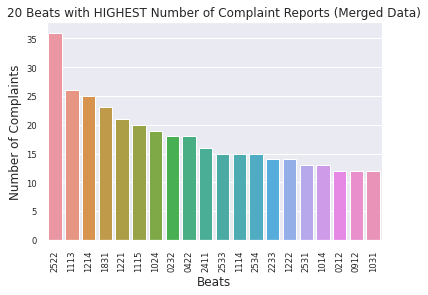

In [92]:
#graph above counter with top 20 beats
sns.set(font_scale = 1)
ax = sns.barplot(x = merged_match_beats[:20].index, y = merged_match_beats[:20], order = merged_match_beats[:20].index, label = 'small')
ax.set_title('20 Beats with HIGHEST Number of Complaint Reports (Merged Data)')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(xlabel='Beats', ylabel='Number of Complaints')
ax.tick_params(labelsize=8.5)
plt.show()

Looking at the Beats with the lowest number of complaints isn't really worthwhile since outside of the top 20 Beats, the vast majority of beats have less than 10 complaints.

Instead, we will just look at the district data of the Top 20 Beats...

In [93]:
#break down top 20 beats into frequency by district
districts_high = {}
for beat in merged_match_beats[:20].index:
    district = beat[:2]
    if district in districts_high.keys():
        districts_high[district] += 1
    else:
        districts_high[district] = 1
#print(districts_high)
districts_high_sorted_keys = sorted(districts_high, key=districts_high.get, reverse=True)
districts_high_sort ={}
for district in districts_high_sorted_keys:
    districts_high_sort[district] = districts_high[district]
print(districts_high_sort)

{'25': 4, '11': 3, '12': 3, '10': 3, '02': 2, '18': 1, '04': 1, '24': 1, '22': 1, '09': 1}


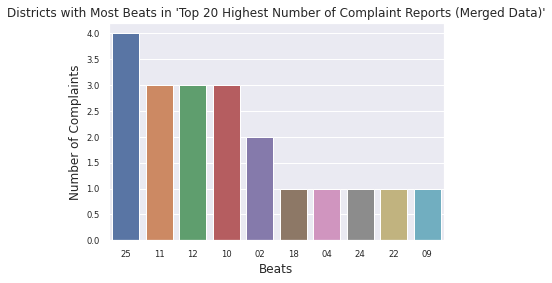

In [94]:
#graph above created district data
sns.set(font_scale = 1)
ax = sns.barplot(x = list(districts_high_sort.keys()), y = list(districts_high_sort.values()), order = list(districts_high_sort.keys()), label = 'small')
ax.set_title('Districts with Most Beats in \'Top 20 Highest Number of Complaint Reports (Merged Data)\'')
ax.set_xticklabels(ax.get_xticklabels())
ax.set(xlabel='Beats', ylabel='Number of Complaints')
ax.tick_params(labelsize=8.5)
plt.show()

Now, race...

In [95]:
#race counter for merged data
df_merged_match.race.value_counts()

BLACK                     878
HISPANIC                  253
WHITE                     151
ASIAN/PACIFIC ISLANDER     11
Name: race, dtype: int64

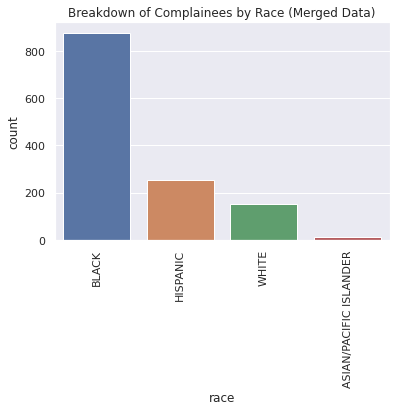

In [96]:
#graph of above counter
ax = sns.countplot(x="race", data=df_merged_match, order = df_merged_match.race.value_counts().index)
ax.set_title('Breakdown of Complainees by Race (Merged Data)')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

Gender...

In [97]:
#gender counter for merged data
df_merged_match.gender.value_counts()

MALE      947
FEMALE    346
Name: gender, dtype: int64

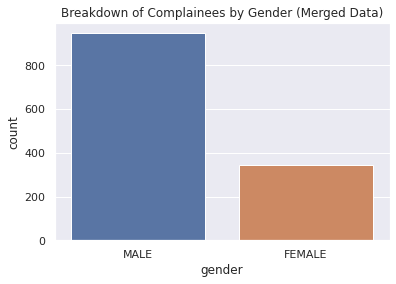

In [98]:
#graph of above counter
ax = sns.countplot(x="gender", data=df_merged_match, order = df_merged_match.gender.value_counts().index)
ax.set_title('Breakdown of Complainees by Gender (Merged Data)')
ax.set_xticklabels(ax.get_xticklabels())
plt.show()

Age...

In [99]:
#age range counter for merged data
df_merged_match.age_band.value_counts()

20-29    409
30-39    314
>=70     274
40-49    120
50-59     75
<20       71
60-69     30
Name: age_band, dtype: int64

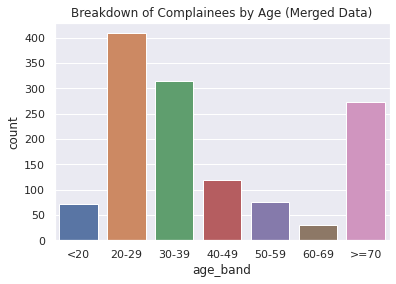

In [100]:
#graph of above counter
age_order = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69','>=70']
ax = sns.countplot(x="age_band", data=df_merged_match, order = age_order)
ax.set_title('Breakdown of Complainees by Age (Merged Data)')
ax.set_xticklabels(ax.get_xticklabels())
plt.show()

Complaint types...

In [101]:
#create counter for most common complaint types in merged data
print('20 Most Frequent Complaint Types (Merged Data) — Table\n')
for key in df_merged_match.complaint_key.value_counts()[:20].index:
    if(key == 'OTHER'):
        print('OTHER')
        print("Frequency: "+str(df_merged_match.complaint_key.value_counts()[key]))
        print('-'*50)
    else:
        print(key+": "+complaint_cat_dict[key])
        print("Frequency: "+str(df_merged_match.complaint_key.value_counts()[key]))
        print('-'*50)

20 Most Frequent Complaint Types (Merged Data) — Table

05A: ARRESTEE - DURING ARREST
Frequency: 229
--------------------------------------------------
03D: ILLEGAL ARREST
Frequency: 172
--------------------------------------------------
10U: INADEQUATE/FAILURE TO PROVIDE SERVICE
Frequency: 138
--------------------------------------------------
03G: MISCELLANEOUS
Frequency: 85
--------------------------------------------------
05Q: CIVIL SUIT - THIRD PARTY
Frequency: 70
--------------------------------------------------
10Z: MISCELLANEOUS
Frequency: 70
--------------------------------------------------
05B: ARRESTEE - AFTER ARREST, PRIOR TO LOCKUP
Frequency: 66
--------------------------------------------------
03B: SEARCH OF PERSON WITHOUT WARRANT
Frequency: 59
--------------------------------------------------
10J: NEGLECT OF DUTY/CONDUCT UNBECOMING - ON DUTY
Frequency: 53
--------------------------------------------------
04E: PRISONER'S PROPERTY - INVENTORY/RECEIPT
Frequency: 50
--

In [102]:
#create counter for least common complaint types in merged data
print('20 Least Frequent Complaint Types (Merged Data) — Table\n')
for key in df_merged_match.complaint_key.value_counts()[-20:].index:
    if(key == 'OTHER'):
        print('OTHER')
        print("Frequency: "+str(df_merged_match.complaint_key.value_counts()[key]))
        print('-'*50)
    else:
        print(key+": "+complaint_cat_dict[key])
        print("Frequency: "+str(df_merged_match.complaint_key.value_counts()[key]))
        print('-'*50)

20 Least Frequent Complaint Types (Merged Data) — Table

02D: D.U.I. - OFF DUTY
Frequency: 6
--------------------------------------------------
07A: MISCONDUCT DURING ISSUANCE OF CITATION
Frequency: 6
--------------------------------------------------
04J: MISCELLANEOUS
Frequency: 6
--------------------------------------------------
14A: STATE CIVIL SUIT
Frequency: 5
--------------------------------------------------
01C: MISCELLANEOUS
Frequency: 5
--------------------------------------------------
05K: DOMESTIC ALTERCATION/INCIDENT - OFF DUTY
Frequency: 5
--------------------------------------------------
10D: COMMUNICATION OPERATIONS PROCEDURES
Frequency: 4
--------------------------------------------------
12D: FAIL TO OBTAIN A COMPLAINT REGISTER NUMBER
Frequency: 4
--------------------------------------------------
07E: FAIL TO ENFORCE TRAFFIC REGULATIONS
Frequency: 4
--------------------------------------------------
05H: MISCELLANEOUS
Frequency: 4
--------------------------------

In [103]:
df_merged_match.reset_index(level =0, inplace = True)

Disciplines...

In [104]:
#counter for recommended disciplines
discipline_dict_rec = {}
discipline_dict_rec['x Day Suspension'] = 0
discipline_dict_rec['Over 30 Day Suspension'] = 0
discipline_dict_rec['Reprimanded'] = 0
discipline_dict_rec['Administrative Termination'] = 0
discipline_dict_rec['Year-long Suspension or Longer'] = 0
discipline_dict_rec['Seperation'] = 0
discipline_dict_rec['Reinstated'] = 0
discipline_dict_rec['Nothing'] = 0
discipline_dict_rec['Resigned'] = 0
for ind in df_merged_match.index:
    rec = df_merged_match['recommended_discipline'][ind]
    if rec <199:
        discipline_dict_rec['x Day Suspension'] += 1
    if rec == 200:
        discipline_dict_rec['Over 30 Day Suspension'] +=1
    if rec == 0 or rec == 100:
        discipline_dict_rec['Reprimanded'] += 1
    if rec == 300:
        discipline_dict_rec['Administrative Termination'] +=1
    if rec == 365:
        discipline_dict_rec['Year-long Suspension or Longer'] +=1
    if rec == 400:
        discipline_dict_rec['Seperation'] += 1
    if rec == 500:
        discipline_dict_rec['Reinstated'] += 1
    if rec == 600 or rec == 900:
        discipline_dict_rec['Nothing'] += 1
    if rec == 800:
        discipline_dict_rec['Resigned'] += 1
discipline_dict_rec_keys = sorted(discipline_dict_rec, key=discipline_dict_rec.get, reverse=True)
discipline_dict_rec_sort ={}
for district in discipline_dict_rec_keys:
    discipline_dict_rec_sort[district] = discipline_dict_rec[district]
print(discipline_dict_rec_sort)

{'Nothing': 1254, 'x Day Suspension': 34, 'Reprimanded': 8, 'Seperation': 4, 'Reinstated': 1, 'Over 30 Day Suspension': 0, 'Administrative Termination': 0, 'Year-long Suspension or Longer': 0, 'Resigned': 0}


In [105]:
#counter for final disciplines
discipline_dict_fin = {}
discipline_dict_fin['x Day Suspension'] = 0
discipline_dict_fin['Over 30 Day Suspension'] = 0
discipline_dict_fin['Reprimanded'] = 0
discipline_dict_fin['Administrative Termination'] = 0
discipline_dict_fin['Year-long Suspension or Longer'] = 0
discipline_dict_fin['Seperation'] = 0
discipline_dict_fin['Reinstated'] = 0
discipline_dict_fin['Nothing'] = 0
discipline_dict_fin['Resigned'] = 0
for ind in df_merged_match.index:
    fin = df_merged_match['final_discipline'][ind]
    if fin <199:
        discipline_dict_fin['x Day Suspension'] += 1
    if fin == 200:
        discipline_dict_fin['Over 30 Day Suspension'] +=1
    if fin == 0 or fin == 100:
        discipline_dict_fin['Reprimanded'] += 1
    if fin == 300:
        discipline_dict_fin['Administrative Termination'] +=1
    if fin == 365:
        discipline_dict_fin['Year-long Suspension or Longer'] +=1
    if fin == 400:
        discipline_dict_fin['Seperation'] += 1
    if fin == 500:
        discipline_dict_fin['Reinstated'] += 1
    if fin == 600 or fin == 900:
        discipline_dict_fin['Nothing'] += 1
    if fin == 800:
        discipline_dict_fin['Resigned'] += 1
discipline_dict_fin_keys = sorted(discipline_dict_fin, key=discipline_dict_fin.get, reverse=True)
discipline_dict_fin_sort ={}
for district in discipline_dict_fin_keys:
    discipline_dict_fin_sort[district] = discipline_dict_fin[district]
print(discipline_dict_fin_sort)

{'Nothing': 1261, 'x Day Suspension': 27, 'Reprimanded': 12, 'Resigned': 4, 'Seperation': 1, 'Over 30 Day Suspension': 0, 'Administrative Termination': 0, 'Year-long Suspension or Longer': 0, 'Reinstated': 0}


In [106]:
#view all discipline data for merged data set + light analysis
print('DISCIPLINE DATA (Merged Data)\n')
for disc in discipline_dict_rec_sort:
    print(disc)
    print('Frequency that '+disc+' was the Recommended Discipline: '+str(discipline_dict_rec[disc]))
    print('Frequency that '+disc+' was the Final Discipline: '+str(discipline_dict_fin[disc]))
    if discipline_dict_rec[disc]>discipline_dict_fin[disc]:
        print('Difference between Recommended and Final Frequencies: '+str(discipline_dict_rec[disc]-discipline_dict_fin[disc])+' ('+ str(abs(discipline_dict_rec[disc]-discipline_dict_fin[disc]))+' more Recommended than Final)')
    elif discipline_dict_rec[disc]<discipline_dict_fin[disc]:
        print('Difference between Recommended and Final Frequencies: '+str(discipline_dict_rec[disc]-discipline_dict_fin[disc])+' ('+ str(abs(discipline_dict_rec[disc]-discipline_dict_fin[disc]))+' more Final than Recommended)')
    else:
        print('Frequencies of Recommended and Final are Equal')
    print('-'*50)

DISCIPLINE DATA (Merged Data)

Nothing
Frequency that Nothing was the Recommended Discipline: 1254
Frequency that Nothing was the Final Discipline: 1261
Difference between Recommended and Final Frequencies: -7 (7 more Final than Recommended)
--------------------------------------------------
x Day Suspension
Frequency that x Day Suspension was the Recommended Discipline: 34
Frequency that x Day Suspension was the Final Discipline: 27
Difference between Recommended and Final Frequencies: 7 (7 more Recommended than Final)
--------------------------------------------------
Reprimanded
Frequency that Reprimanded was the Recommended Discipline: 8
Frequency that Reprimanded was the Final Discipline: 12
Difference between Recommended and Final Frequencies: -4 (4 more Final than Recommended)
--------------------------------------------------
Seperation
Frequency that Seperation was the Recommended Discipline: 4
Frequency that Seperation was the Final Discipline: 1
Difference between Recommende

In [107]:
#view of discpline comparison counter
print('Compare Disciplines for DF_DETAIL (with duplicates)\n')
print(df_merged_match.compare_discipline.value_counts())

Compare Disciplines for DF_DETAIL (with duplicates)

EQUAL                       1267
LESS THAN RECOMMENDED         17
GREATER THAN RECOMMENDED       9
Name: compare_discipline, dtype: int64


Findings...

In [108]:
#counter and view for findings (recommended) in merged
smthCount = 0
for ind in df_merged_match.index:
    recFin = df_merged_match['recommended_finding'][ind]
    if recFin == 'SU':
        smthCount += 1
totLen = len(df_merged_match['recommended_finding'].notnull())
print('Recommended Finding Data (Merged Data)\n')
print('Number of Findings that were \'Something\': '+ str(smthCount))
print('Number of Total Findings: ' + str(totLen))
print('Percentage of \'Something\' Findings: '+str(smthCount/totLen*100)+'%')

Recommended Finding Data (Merged Data)

Number of Findings that were 'Something': 38
Number of Total Findings: 1293
Percentage of 'Something' Findings: 2.9389017788089715%


In [109]:
#counter and view for findings (final) in merged
smthCount = 0
for ind in df_merged_match.index:
    recFin = df_merged_match['final_finding'][ind]
    if recFin == 'SU':
        smthCount += 1
totLen = len(df_merged_match['final_finding'].notnull())
print('Final Finding Data (Merged Data)\n')
print('Number of Findings that were \'Something\': '+ str(smthCount))
print('Number of Total Findings: ' + str(totLen))
print('Percentage of \'Something\' Findings: '+str(smthCount/totLen*100)+'%')

Final Finding Data (Merged Data)

Number of Findings that were 'Something': 34
Number of Total Findings: 1293
Percentage of 'Something' Findings: 2.6295436968290797%


In [110]:
#counter and view for the differences in recommended and final finding
diffCount = 0
for ind in df_merged_match.index:
    recFin = df_merged_match['recommended_finding'][ind]
    finFin = df_merged_match['final_finding'][ind]
    if recFin == 'SU' and finFin != 'SU' and pd.notnull(finFin):
        diffCount += 1
    if finFin == 'SU' and recFin != 'SU' and pd.notnull(recFin):
        diffCount+=1
totLen = len(df_merged_match['recommended_finding'].notnull())
print('Finding Comparison Data (Merged Data)')
print('Number of Incidnets where Recommended and Final Findings Do Not Coincide: '+str(diffCount))
print('Total Number of Incidents: '+str(totLen))
print('Percentage of Differenct Recommended and Final Findings: '+str(diffCount/totLen*100)+'%')

Finding Comparison Data (Merged Data)
Number of Incidnets where Recommended and Final Findings Do Not Coincide: 4
Total Number of Incidents: 1293
Percentage of Differenct Recommended and Final Findings: 0.30935808197989173%


In [111]:
#counter of comparisons on findings for merged data
print('Finding Data on Differences between Recommended and Final Findings (Merged Data)\n')
print(df_merged_match.compare_findings.value_counts())

Finding Data on Differences between Recommended and Final Findings (Merged Data)

EQUAL                    1289
LESS THAN RECOMMENDED       4
Name: compare_findings, dtype: int64


Writing the top and bottom 20 beats in complaints to an output file:

In [112]:
outF = open("complaints.txt", "w")

In [113]:
outF.write('T20 Complaints: \n')
for ind in beatFreq.index:
    beat = str(ind)
    outF.write(beat+" ")
outF.write('\n')

1

In [114]:
outF.write('L20 Complaints: \n')
for ind in beatFreq_low.index:
    beat = str(ind)
    outF.write(beat+" ")
outF.write('\n')
outF.close()